In [1]:
import os
os.environ["CUBLAS_WORKSPACE_CONFIG"] = ":4096:8"  # Must be first!

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from torch.optim.lr_scheduler import (
    ReduceLROnPlateau,
    LambdaLR
)
from torch.utils.tensorboard import SummaryWriter

import polars as pl
from tqdm.notebook import tqdm

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import random
import numpy as np

###################
from model import EEGMobileNet
from dataset import EEGDatasetV2
# from utils import collate_fn
from torch.nn.utils.rnn import pad_sequence

###################

# Set seeds and deterministic flags
random.seed(69)
np.random.seed(69)
torch.manual_seed(69)
torch.cuda.manual_seed(69)
torch.use_deterministic_algorithms(True)  # Enable full determinism
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

In [2]:
pl.read_parquet('/home/owner/Documents/DEV/BrainLabyrinth/data/combined_prev_prev_2.parquet')

event_id,orig_marker,time,Fp1,Fpz,Fp2,F7,F3,Fz,F4,F8,FC5,FC1,FC2,FC6,M1,T7,C3,Cz,C4,T8,M2,CP5,CP1,CP2,CP6,P7,P3,Pz,P4,P8,POz,O1,O2,AF7,AF3,AF4,AF8,F5,F1,F2,F6,FC3,FCz,FC4,C5,C1,C2,C6,CP3,CP4,P5,P1,P2,P6,PO5,PO3,PO4,PO6,FT7,FT8,TP7,TP8,PO7,PO8,Oz,prev_prev_marker,prev_marker,marker
i64,str,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,str,str,str
0,"""Stimulus/P""",22.746,-21.377546,-3.329028,-18.758145,-30.73564,-27.979262,-17.733182,-11.122367,10.858938,-44.451512,-12.26531,-11.228322,-7.163317,-14.05838,-30.227744,-31.09242,-12.310457,-37.415239,-10.066313,-17.291664,-34.362408,11.172778,-5.593829,-11.168018,-35.016279,-24.367157,-11.756309,-25.158083,-11.400707,-9.222274,-26.857691,-28.989126,-35.296483,-18.676274,-2.265123,-0.681522,-27.036101,-17.27791,-14.018948,-0.860448,-24.590269,-11.165179,-15.876778,-15.611566,-15.470771,-11.342499,-0.354879,-47.082836,-25.75458,-23.214993,-28.41397,-32.145426,-23.09293,-18.515905,-18.41682,-2.948578,-29.370747,-31.412779,-7.822252,-27.387539,-27.833376,-17.620415,-29.850262,-16.782366,"""Left""","""Right""","""Right"""
0,"""Stimulus/P""",22.748,-21.219501,-3.171698,-18.695978,-30.899023,-27.964396,-17.633559,-10.771049,11.624404,-44.61444,-11.903594,-10.694397,-7.173872,-14.512791,-29.422429,-30.804771,-11.544276,-37.174302,-5.694034,-15.207482,-34.277941,11.258942,-5.45682,-11.079793,-34.895782,-24.831925,-11.852139,-25.596388,-11.766606,-9.404878,-27.45209,-29.890226,-35.150051,-18.198552,-1.781131,-0.387058,-26.465131,-16.855895,-13.527142,0.034495,-24.553398,-10.965987,-15.584374,-15.866586,-15.515992,-11.014299,-0.915622,-47.12713,-25.906854,-23.593264,-28.479127,-32.260117,-23.671744,-18.869104,-18.846811,-3.254924,-30.022285,-31.631908,-6.706748,-27.717578,-26.271575,-17.999255,-30.66878,-17.174672,"""Left""","""Right""","""Right"""
0,"""Stimulus/P""",22.75,-21.107591,-3.092899,-18.653458,-31.489265,-28.012768,-17.474946,-10.519029,12.088246,-45.094286,-11.5613,-10.089097,-7.148177,-15.480021,-28.509242,-30.69717,-10.76844,-36.881722,-3.919959,-13.700795,-34.221406,11.324101,-5.275087,-10.958402,-34.506983,-25.011003,-11.901826,-25.887634,-12.305291,-9.472896,-27.557485,-30.611738,-35.342925,-17.875566,-1.327837,-0.237936,-25.884175,-16.47395,-13.142645,0.856802,-24.602636,-10.661366,-15.28256,-16.268992,-15.581594,-10.649388,-1.149936,-47.226449,-26.028439,-23.705772,-28.537429,-32.317398,-24.173332,-18.842379,-18.952802,-3.564849,-30.51049,-32.262253,-5.861874,-28.14821,-25.338115,-17.990954,-31.322179,-16.965819,"""Left""","""Right""","""Right"""
0,"""Stimulus/P""",22.752,-21.006886,-3.056991,-18.582953,-32.411302,-28.069638,-17.238215,-10.384327,12.253836,-45.787117,-11.235732,-9.436472,-7.044266,-16.833204,-27.524872,-30.745046,-10.0373,-36.523804,-4.812991,-12.846942,-34.155775,11.375401,-5.041548,-10.786247,-33.837596,-24.853686,-11.903567,-25.986433,-12.937813,-9.399739,-27.148928,-31.042835,-35.812823,-17.689045,-0.922058,-0.185608,-25.297602,-16.130204,-12.878529,1.541432,-24.679923,-10.259005,-14.956661,-16.743237,-15.629367,-10.255516,-0.988882,-47.336807,-26.087693,-23.51264,-28.561456,-32.291279,-24.516449,-18.415956,-18.701083,-3.820157,-30.758124,-33.167084,-5.325221,-28.585937,-25.039198,-17.584963,-31.720538,-16.191491,"""Left""","""Right""","""Right"""
0,"""Stimulus/P""",22.754,-20.872785,-3.017698,-18.431995,-33.530736,-28.07893,-16.911503,-10.372313,12.147042,-46.564886,-10.917663,-8.764207,-6.83163,-18.402727,-26.528758,-30.907434,-9.397617,-36.09857,-8.137851,-12.662949,-34.050964,11.419024,-4.761436,-10.570737,-32.913805,-24.350841,-11.86542,-25.886998,-13.604752,-9.183589,-26.25909,-31.129443,-36.458857,-17.601949,-0.578673,-0.170892,-24.714531,-15.811797,-12.733076,2.042612,-24.727222,-9.773674,-14.59811,-17.214512,-15.624975,-9.844416,-0.4239

In [3]:
def train_model(config, train_set, train_loader, val_loader, writer):
    # -------------------- MODEL --------------------
    model = EEGMobileNet(
        in_channels=65,
        num_classes=1,
        dropout=config['dropout']
    ).to(config['device'])
        
    for name, layer in model.named_modules():
        if isinstance(layer, nn.BatchNorm1d):
            assert not layer.track_running_stats, \
                f"BatchNorm layer {name} should have track_running_stats=False"
    
    # Log model architecture and config
    writer.add_text("Model/Type", f"EEGMobileNet with dropout={config['dropout']}")
    writer.add_text("Model/Structure", str(model))
    writer.add_text("Training Config", str(config))
    
    # ------------------ LOSS FUNCTION ------------------
    
    
    class_counts = train_set.class_weights # Fetches {'Left_count': N, 'Right_count': M}

    count_L = class_counts.get('Left', 1)  # Default to 1 to prevent division by zero errors later
    count_R = class_counts.get('Right', 1)  # Default to 1

    # Calculate the pos_weight value = count_negative / count_positive
    # Add a check for count_R being zero
    if count_R > 0:
        pos_weight_value = count_L / count_R
    else:
        pos_weight_value = 1.0 # Assign a default weight if the positive class has zero samples
        print(f"Warning: Positive class (Right/1) has count {count_R}. Setting pos_weight to 1.0.")

    print(f"Class counts: Left={count_L}, Right={count_R}")
    print(f"Calculated pos_weight for BCEWithLogitsLoss: {pos_weight_value:.4f}")
    
    pos_weight = torch.tensor([pos_weight_value]).to(config['device'])
    criterion = torch.nn.BCEWithLogitsLoss(weight=pos_weight)
    
    # ------------------- OPTIMIZER ---------------------
    lr = config.get('lr', 1e-3)
    weight_decay = config.get('weight_decay', 1e-2)
    
    optimizer = optim.AdamW(model.parameters(), lr=lr, weight_decay=weight_decay)
    
    # ------------------- SCHEDULER ---------------------
    scheduler_config = config.get('scheduler', {})
    scheduler = ReduceLROnPlateau(
        optimizer,
        mode=scheduler_config.get('mode', 'min'),
        factor=scheduler_config.get('factor', 0.1),
        patience=scheduler_config.get('patience', 10),
        threshold=scheduler_config.get('threshold', 0.0001),
        cooldown=scheduler_config.get('cooldown', 0),
        min_lr=scheduler_config.get('min_lr', 0),
    )
    
    # ------------------- WARMUP SCHEDULER ---------------
    warmup_epochs = config.get('warmup_epochs', 0)
    if warmup_epochs > 0:
        warmup_scheduler = LambdaLR(
            optimizer,
            lambda epoch: min(1.0, (epoch + 1) / warmup_epochs)
        )
    else:
        warmup_scheduler = None
    
    # -------------------- TRAINING LOOP --------------------
    best_metric = -float('inf')
    
    for epoch in tqdm(range(config['epochs']), desc="Training"):
        # ---------- TRAIN ----------
        model.train()
        train_loss = 0.0
        
        for labels, features, _ in train_loader:
            features = features.to(config['device']).float()
            labels = labels.to(config['device']).float()
            
            optimizer.zero_grad()
            outputs = model(features).squeeze(1)
            loss = criterion(outputs, labels)
            loss.backward()
            
            # Gradient clipping (if specified)
            if config.get('grad_clip') is not None:
                torch.nn.utils.clip_grad_norm_(model.parameters(), config['grad_clip'])
            
            optimizer.step()
            train_loss += loss.item()
        
        train_loss /= len(train_loader)
        
        # ---------- VALIDATION ----------
        model.eval()
        val_loss = 0.0
        all_preds = []
        all_labels = []
        
        with torch.no_grad():
            for labels, features, _ in val_loader:
                features = features.to(config['device']).float()
                labels = labels.to(config['device']).float()
                
                outputs = model(features).squeeze(1)
                loss = criterion(outputs, labels)
                val_loss += loss.item()
                
                preds = torch.sigmoid(outputs)
                all_preds.extend(preds.cpu().numpy())
                all_labels.extend(labels.cpu().numpy())
        
        val_loss /= len(val_loader)
        predictions = (np.array(all_preds) > 0.5).astype(int)
        
        # ---------- METRICS ----------
        accuracy = accuracy_score(all_labels, predictions)
        precision = precision_score(all_labels, predictions)
        recall = recall_score(all_labels, predictions)
        f1 = f1_score(all_labels, predictions)
        
        # ---------- SCHEDULER UPDATE ----------
        current_lr = optimizer.param_groups[0]['lr']
        
        if warmup_scheduler is not None and epoch < warmup_epochs:
            warmup_scheduler.step()
        else:
            if scheduler is not None:
                scheduler.step(val_loss)
        
        # ---------- LOGGING ----------
        writer.add_scalar('LR', current_lr, epoch)
        writer.add_scalar('Loss/Train', train_loss, epoch)
        writer.add_scalar('Loss/Val', val_loss, epoch)
        writer.add_scalar('Accuracy', accuracy, epoch)
        writer.add_scalar('Precision', precision, epoch)
        writer.add_scalar('Recall', recall, epoch)
        writer.add_scalar('F1', f1, epoch)
        
        # You can also combine them in a single dictionary
        metrics = {
            'accuracy': accuracy,
            'precision': precision,
            'recall': recall,
            'f1': f1
        }
        writer.add_scalars('Metrics', metrics, epoch)
        
        # ---------- SAVE BEST MODEL ----------
        if accuracy > best_metric:
            best_metric = accuracy
            torch.save(model.state_dict(), f"{config['log_dir']}/best_model.pth")
    
    writer.close()
    return model


In [4]:
import pickle
with open('baseline_CNN_V2.pkl', 'rb') as f:
    config_study = pickle.load(f)
    
required_keys = ['lr', 'weight_decay', 'dropout', 'factor', 'patience', 'cooldown']
assert all(k in config_study for k in required_keys), \
    f"Missing Optuna parameters: {set(required_keys) - set(config_study.keys())}"
    
config_study

{'lr': 7.874218712024844e-05,
 'weight_decay': 6.044655803896766e-06,
 'dropout': 0.4991027500704538,
 'factor': 0.127815027666582,
 'patience': 18,
 'cooldown': 12}

In [5]:
config = {
    'data_path': '/home/owner/Documents/DEV/BrainLabyrinth/data/combined_prev_prev_2.parquet',
    'split_ratios': (0.7, 0.15, 0.15),
    'batch_size': 32,
    'dropout': config_study['dropout'],
    'epochs': 300,
    'device': torch.device('cuda' if torch.cuda.is_available() else 'cpu'),
    'log_dir': './runs/CNN',

    # <<< Global LR and Weight Decay here >>>
    'lr': config_study['lr'],
    'weight_decay': config_study['weight_decay'],
    'factor': config_study['factor'],
    'patience': config_study['patience'],
    'cooldown': config_study['cooldown'],
    
    # Optimizer config (without lr/weight_decay)
    'optimizer': {
        'mode': 'min',
        'factor': config_study['factor'],      # From Optuna
        'patience': config_study['patience'],  # From Optuna
        'cooldown': config_study['cooldown'],  # From Optuna
        'min_lr': 1e-8,
        'threshold': 0.0001,
    },

    # Scheduler config
    'scheduler': {
        'mode': 'min',
        'factor': config_study['factor'],
        'patience': config_study['patience'],
        'threshold': 0.0001,
        'cooldown': config_study['cooldown'],
        'min_lr': 1e-8
    },

    'warmup_epochs': 0,
    'grad_clip': None
}



In [ ]:
# #============================================================
# # Training Pipeline
# #============================================================
# import warnings
# warnings.filterwarnings("ignore", category=FutureWarning)

# # Initialize dataset
# print("Creating full dataset...")
# full_dataset = EEGDatasetV2(config['data_path'])

# print(full_dataset.class_weights)

# print("Splitting the dataset...")
# # Split dataset
# train_set, val_set, test_set = full_dataset.split_dataset(
#     ratios=config['split_ratios']
# )

# del full_dataset

# len_dataset = len(train_set)
# sample = train_set[0]
# label_shape = sample[0].shape
# feature_shape = sample[1].shape

# print(f"unbalanced train dataset shape: ({len_dataset}, [labels: {label_shape}, features: {list(feature_shape)}])")

# torch.save(train_set, 'train_set.pt')
# torch.save(val_set, 'val_set.pt')
# torch.save(test_set, 'test_set.pt')

Creating full dataset...
['Fp1', 'Fpz', 'Fp2', 'F7', 'F3', 'Fz', 'F4', 'F8', 'FC5', 'FC1', 'FC2', 'FC6', 'M1', 'T7', 'C3', 'Cz', 'C4', 'T8', 'M2', 'CP5', 'CP1', 'CP2', 'CP6', 'P7', 'P3', 'Pz', 'P4', 'P8', 'POz', 'O1', 'O2', 'AF7', 'AF3', 'AF4', 'AF8', 'F5', 'F1', 'F2', 'F6', 'FC3', 'FCz', 'FC4', 'C5', 'C1', 'C2', 'C6', 'CP3', 'CP4', 'P5', 'P1', 'P2', 'P6', 'PO5', 'PO3', 'PO4', 'PO6', 'FT7', 'FT8', 'TP7', 'TP8', 'PO7', 'PO8', 'Oz', 'prev_prev_marker', 'prev_marker']
Precomputing samples...


precomputing_samples:   0%|          | 0/2752 [00:00<?, ?it/s]

Computing class weights...
{'Left': 0.0007331378299120235, 'Right': 0.0007204610951008645}
Splitting the dataset...
['Fp1', 'Fpz', 'Fp2', 'F7', 'F3', 'Fz', 'F4', 'F8', 'FC5', 'FC1', 'FC2', 'FC6', 'M1', 'T7', 'C3', 'Cz', 'C4', 'T8', 'M2', 'CP5', 'CP1', 'CP2', 'CP6', 'P7', 'P3', 'Pz', 'P4', 'P8', 'POz', 'O1', 'O2', 'AF7', 'AF3', 'AF4', 'AF8', 'F5', 'F1', 'F2', 'F6', 'FC3', 'FCz', 'FC4', 'C5', 'C1', 'C2', 'C6', 'CP3', 'CP4', 'P5', 'P1', 'P2', 'P6', 'PO5', 'PO3', 'PO4', 'PO6', 'FT7', 'FT8', 'TP7', 'TP8', 'PO7', 'PO8', 'Oz', 'prev_prev_marker', 'prev_marker']
Precomputing samples...


precomputing_samples:   0%|          | 0/1926 [00:00<?, ?it/s]

Computing class weights...
['Fp1', 'Fpz', 'Fp2', 'F7', 'F3', 'Fz', 'F4', 'F8', 'FC5', 'FC1', 'FC2', 'FC6', 'M1', 'T7', 'C3', 'Cz', 'C4', 'T8', 'M2', 'CP5', 'CP1', 'CP2', 'CP6', 'P7', 'P3', 'Pz', 'P4', 'P8', 'POz', 'O1', 'O2', 'AF7', 'AF3', 'AF4', 'AF8', 'F5', 'F1', 'F2', 'F6', 'FC3', 'FCz', 'FC4', 'C5', 'C1', 'C2', 'C6', 'CP3', 'CP4', 'P5', 'P1', 'P2', 'P6', 'PO5', 'PO3', 'PO4', 'PO6', 'FT7', 'FT8', 'TP7', 'TP8', 'PO7', 'PO8', 'Oz', 'prev_prev_marker', 'prev_marker']
Precomputing samples...


precomputing_samples:   0%|          | 0/412 [00:00<?, ?it/s]

Computing class weights...
['Fp1', 'Fpz', 'Fp2', 'F7', 'F3', 'Fz', 'F4', 'F8', 'FC5', 'FC1', 'FC2', 'FC6', 'M1', 'T7', 'C3', 'Cz', 'C4', 'T8', 'M2', 'CP5', 'CP1', 'CP2', 'CP6', 'P7', 'P3', 'Pz', 'P4', 'P8', 'POz', 'O1', 'O2', 'AF7', 'AF3', 'AF4', 'AF8', 'F5', 'F1', 'F2', 'F6', 'FC3', 'FCz', 'FC4', 'C5', 'C1', 'C2', 'C6', 'CP3', 'CP4', 'P5', 'P1', 'P2', 'P6', 'PO5', 'PO3', 'PO4', 'PO6', 'FT7', 'FT8', 'TP7', 'TP8', 'PO7', 'PO8', 'Oz', 'prev_prev_marker', 'prev_marker']
Precomputing samples...


precomputing_samples:   0%|          | 0/414 [00:00<?, ?it/s]

Computing class weights...
unbalanced train dataset shape: (1926, [labels: torch.Size([]), features: [2000, 65]])


In [7]:

train_set = torch.load('train_set.pt', weights_only=False)
val_set = torch.load('val_set.pt', weights_only=False)
test_set = torch.load('test_set.pt', weights_only=False)

def collate_fn(batch):
    labels, features, original_labels = zip(*batch)
    labels = torch.stack(labels)
    # Pad sequences, resulting shape: (batch_size, max_seq_len, num_channels)
    padded_features = pad_sequence(features, batch_first=True)
    original_labels = torch.stack(original_labels)

    # Transpose features to shape: (batch_size, num_channels, max_seq_len)
    transposed_features = padded_features.transpose(1, 2)

    return labels, transposed_features, original_labels


generator = torch.Generator().manual_seed(69)  # Set seed
train_loader = DataLoader(
    train_set,
    batch_size=config['batch_size'],
    shuffle=True,
    generator=generator,  # Add this line
    num_workers=0,
    pin_memory=True,
    # persistent_workers=True,
    collate_fn=collate_fn
)
val_loader = DataLoader(val_set, batch_size=config['batch_size'], collate_fn=collate_fn)
test_loader = DataLoader(test_set, batch_size=config['batch_size'], collate_fn=collate_fn)

len_dataset = len(train_set)
sample = train_set[0]
label_shape = sample[0].shape
feature_shape = sample[1].shape

print(f"train dataset shape: ({len_dataset}, [labels: {label_shape}, features: {list(feature_shape)}])")


# Set up logging
writer = SummaryWriter(log_dir=config['log_dir'])

train dataset shape: (1926, [labels: torch.Size([]), features: [2000, 65]])


In [8]:
# test_set.df.columns

In [9]:
# # Start training
# print("Applying seeds immediately before training...")
# random.seed(69)
# np.random.seed(69)
# torch.manual_seed(69)
# torch.cuda.manual_seed(69)
# # Ensure deterministic algorithms are still enabled (should be from top)
# torch.use_deterministic_algorithms(True)
# torch.backends.cudnn.deterministic = True
# torch.backends.cudnn.benchmark = False

# trained_model = train_model(config, train_set, train_loader, val_loader, writer)

  0%|          | 0/13 [00:00<?, ?it/s]

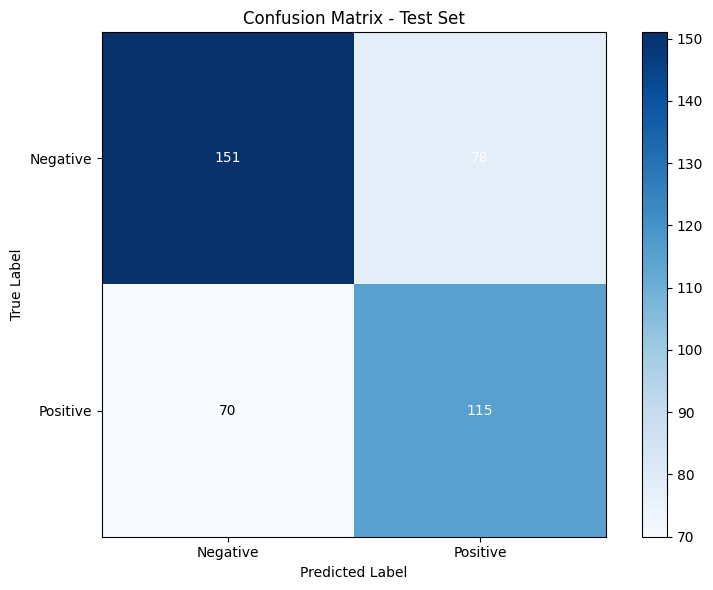

In [12]:
import torch
from tqdm.notebook import tqdm
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix
import matplotlib.pyplot as plt
import numpy as np
import io
from PIL import Image
import torchvision.transforms as transforms

# Assuming EEGMobileNet and config are defined elsewhere
# from your_model_file import EEGMobileNet  # Import your model
# config = {...}  # Your configuration dictionary
# writer = ... # Your TensorBoard writer


best_model = EEGMobileNet(in_channels=65)  # Adjust parameters as needed

# Load the state dictionary
state_dict = torch.load(f"{config['log_dir']}/best_model.pth", map_location=config['device'])
best_model.load_state_dict(state_dict)

# Move model to the correct device
best_model = best_model.to(config['device'])

# Set model to evaluation mode
best_model.eval()

test_loss = 0
all_test_markers = []
all_test_predictions = []
all_test_original_markers = []
with torch.no_grad():
    for markers, features, original_markers in tqdm(test_loader): #  Iterate through your test data loader
        features = features.to(config['device'])
        markers = markers.to(config['device'])

        outputs = best_model(features)

        # Collect markers and predictions for metrics calculation
        all_test_markers.extend(markers.cpu().numpy().flatten())
        all_test_predictions.extend(torch.sigmoid(outputs).cpu().numpy().flatten())
        all_test_original_markers.extend(original_markers.cpu().numpy().flatten())

# Calculate test metrics
test_accuracy = accuracy_score(all_test_markers, [1 if p > 0.5 else 0 for p in all_test_predictions])
test_precision = precision_score(all_test_markers, [1 if p > 0.5 else 0 for p in all_test_predictions])
test_recall = recall_score(all_test_markers, [1 if p > 0.5 else 0 for p in all_test_predictions])
test_f1 = f1_score(all_test_markers, [1 if p > 0.5 else 0 for p in all_test_predictions])
test_roc_auc = roc_auc_score(all_test_markers, all_test_predictions)

# Log test metrics to TensorBoard
writer.add_scalar('Metrics/test_accuracy', test_accuracy, 1)
writer.add_scalar('Metrics/test_precision', test_precision, 1)
writer.add_scalar('Metrics/test_recall', test_recall, 1)
writer.add_scalar('Metrics/test_f1', test_f1, 1)
writer.add_scalar('Metrics/test_roc_auc', test_roc_auc, 1)



# Calculate confusion matrix
test_confusion_matrix = confusion_matrix(all_test_markers, [1 if p > 0.5 else 0 for p in all_test_predictions])

# Plot confusion matrix
plt.figure(figsize=(8, 6))
plt.imshow(test_confusion_matrix, cmap='Blues')
plt.title('Confusion Matrix - Test Set')
plt.colorbar()
tick_marks = np.arange(2)
plt.xticks(tick_marks, ['Negative', 'Positive'])
plt.yticks(tick_marks, ['Negative', 'Positive'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')

# Add text annotations to the confusion matrix
thresh = test_confusion_matrix.max() / 2.
for i, j in np.ndindex(test_confusion_matrix.shape):
    plt.text(j, i, format(test_confusion_matrix[i, j], 'd'),
             ha="center", va="center",
             color="white" if test_confusion_matrix[i, j] > thresh else "black")
plt.tight_layout()

# Close the TensorBoard writer
writer.close()


In [ ]:
print(f"""
{test_accuracy=}
{test_precision=}
{test_recall=}
{test_f1=}
{test_roc_auc=}
"""
)


test_accuracy=0.642512077294686
test_precision=0.5958549222797928
test_recall=0.6216216216216216
test_f1=0.6084656084656085
test_roc_auc=np.float64(0.6943231441048034)



In [ ]:
from sklearn.metrics import f1_score
import numpy as np
best_threshold = 0.0
best_f1 = 0.0
thresholds = np.arange(0.1, 1.0, 0.01)

for threshold in tqdm(thresholds):
    binary_predictions = (all_test_predictions > threshold).astype(int)
    current_recall = f1_score(all_test_markers, binary_predictions)

    if current_recall > best_f1:
        best_f1 = current_recall
        best_threshold = threshold

print(f"{best_threshold=}")
print(f"{best_f1=}")

  0%|          | 0/90 [00:00<?, ?it/s]

best_threshold=np.float64(0.3699999999999999)
best_f1=0.6823529411764706


In [ ]:
from sklearn.metrics import accuracy_score
import numpy as np
best_threshold = 0.1
best_accuracy = 0.0
thresholds = np.arange(0.005, 1.0, 0.005)

for threshold in tqdm(thresholds):
    binary_predictions = (all_test_predictions > threshold).astype(int) 
    current_recall = accuracy_score(all_test_markers, binary_predictions)

    if current_recall > best_accuracy:
        best_accuracy = current_recall
        best_threshold = threshold
        precision = precision_score(all_test_markers, [1 if p > threshold else 0 for p in all_test_predictions])
        recall = recall_score(all_test_markers, [1 if p > threshold else 0 for p in all_test_predictions])
        f1 = f1_score(all_test_markers, [1 if p > threshold else 0 for p in all_test_predictions])
        roc_auc = roc_auc_score(all_test_markers, all_test_predictions)

print(f"{best_threshold=}")
print(f"""
{best_accuracy=}
{precision=}
{recall=}
{f1=}
{roc_auc=}
""")

  0%|          | 0/199 [00:00<?, ?it/s]

best_threshold=np.float64(0.4)

best_accuracy=0.678743961352657
precision=0.6130434782608696
recall=0.7621621621621621
f1=0.6795180722891566
roc_auc=np.float64(0.6943231441048034)



In [ ]:
from collections import Counter

statuses = []
test_rightness =  all_test_markers == np.array([1 if p > best_threshold else 0 for p in all_test_predictions])
for original_marker, positive_verdict in zip(all_test_original_markers, test_rightness):
    if original_marker == 1:
        if positive_verdict:
            statuses.append('Stimulus/P right')
        else:
            statuses.append('Stimulus/P wrong')
    else:
        if positive_verdict:
            statuses.append('Stimulus/A right')
        else:
            statuses.append('Stimulus/A wrong')


results_counter = Counter(statuses)



# --- Extract counts ---
# Use .get() for safety in case a key is missing (though not in this example)
stim_A_right = results_counter.get('Stimulus/A right', 0)
stim_A_wrong = results_counter.get('Stimulus/A wrong', 0)
stim_P_right = results_counter.get('Stimulus/P right', 0)
stim_P_wrong = results_counter.get('Stimulus/P wrong', 0)

# --- Calculate totals ---
total_A_events = stim_A_right + stim_A_wrong
total_P_events = stim_P_right + stim_P_wrong

total_right_predictions = stim_A_right + stim_P_right
total_wrong_predictions = stim_A_wrong + stim_P_wrong
total_events = total_right_predictions + total_wrong_predictions

# --- Calculate Metrics ---

# 1. Overall Accuracy of the Rules
# (How often did the rule correctly predict the outcome?)
overall_accuracy = total_right_predictions / total_events if total_events > 0 else 0.0

# 2. Accuracy of Rule A (Flip)
# (When Stimulus/A was shown, how often was flipping the correct strategy?)
accuracy_A = stim_A_right / total_A_events if total_A_events > 0 else 0.0

# 3. Accuracy of Rule P (Persist)
# (When Stimulus/P was shown, how often was persisting the correct strategy?)
accuracy_P = stim_P_right / total_P_events if total_P_events > 0 else 0.0

# --- Print Results ---
print("--- Metrics Based on Rule Application Success ---")
print(f"Total Events Analyzed (A + P): {total_events}")
print("-" * 20)
print(f"Stimulus/A Events: {total_A_events}")
print(f"  - Rule 'Flip' Correct: {stim_A_right}")
print(f"  - Rule 'Flip' Incorrect: {stim_A_wrong}")
print(f"  - Accuracy of 'Flip' Rule: {accuracy_A:.4f}")
print("-" * 20)
print(f"Stimulus/P Events: {total_P_events}")
print(f"  - Rule 'Persist' Correct: {stim_P_right}")
print(f"  - Rule 'Persist' Incorrect: {stim_P_wrong}")
print(f"  - Accuracy of 'Persist' Rule: {accuracy_P:.4f}")
print("-" * 20)
print(f"Overall Accuracy (Rule matched outcome): {overall_accuracy:.4f}")
print("-" * 20)

print("\nNote:")
print("These metrics evaluate the success rate of the simple 'Flip'/'Persist' heuristics.")
print("They are NOT standard classification metrics like Precision, Recall, or F1-Score ")

--- Metrics Based on Rule Application Success ---
Total Events Analyzed (A + P): 414
--------------------
Stimulus/A Events: 268
  - Rule 'Flip' Correct: 219
  - Rule 'Flip' Incorrect: 49
  - Accuracy of 'Flip' Rule: 0.8172
--------------------
Stimulus/P Events: 146
  - Rule 'Persist' Correct: 62
  - Rule 'Persist' Incorrect: 84
  - Accuracy of 'Persist' Rule: 0.4247
--------------------
Overall Accuracy (Rule matched outcome): 0.6787
--------------------

Note:
These metrics evaluate the success rate of the simple 'Flip'/'Persist' heuristics.
They are NOT standard classification metrics like Precision, Recall, or F1-Score 


Model loaded successfully from ./runs/CNN/best_model.pth

--- Starting Model Interpretation Analysis ---

Analyzing Filter Activations...
Attempting to get activations from layer: model.0
Shape of activations from layer 'model.0': torch.Size([32, 32, 1000])


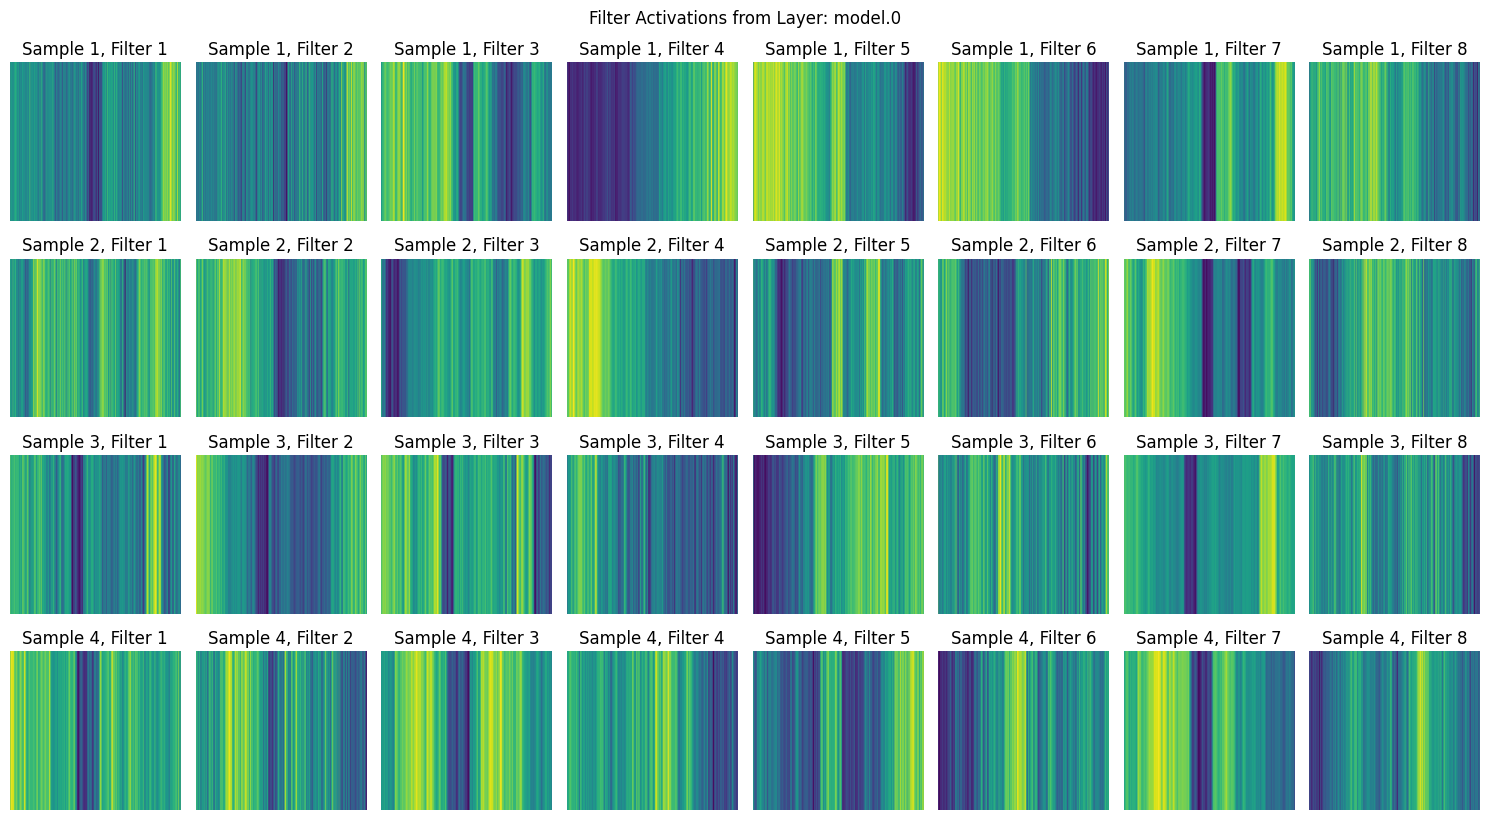

In [ ]:
import torch
import numpy as np
import matplotlib.pyplot as plt

if test_set is not None:
    # Load the trained model
    # Ensure EEGMobileNet is defined and accessible (e.g., in model.py)
    try:
        # Adjust in_channels and num_classes based on your EEGMobileNet definition
        best_model = EEGMobileNet(in_channels=65, num_classes=1, dropout=config.get('dropout', 0.5)) # Use dropout from config if available
        model_path = f"{config['log_dir']}/best_model.pth"

        state_dict = torch.load(model_path, map_location=config['device'])
        best_model.load_state_dict(state_dict)
        best_model = best_model.to(config['device'])
        best_model.eval() # Set model to evaluation mode
        print(f"Model loaded successfully from {model_path}")

    except FileNotFoundError:
        print(f"Error: best_model.pth not found at {model_path}. Please ensure the training notebook was run to save the model.")
        best_model = None
    except NameError:
            print("Error: EEGMobileNet class not found. Make sure model.py is in the same directory or its path is included.")
            best_model = None
    except Exception as e:
        print(f"Error loading model: {e}")
        best_model = None

# --- Perform Interpretation Analysis ---
if best_model is not None and test_loader is not None and test_set is not None:
    print("\n--- Starting Model Interpretation Analysis ---")

# --- 1. Analysis of Filter Activations ---
print("\nAnalyzing Filter Activations...")

# Get a sample batch from the test loader
# Taking the first batch for demonstration
# Make sure test_loader provides labels, features, and original_labels
sample_labels, sample_features, sample_original_labels = next(iter(test_loader))


sample_features = sample_features.to(config['device']).float()

# Transpose features before passing to the model for activation analysis
# Shape becomes (batch_size, channels, seq_len)


# Define a function to get activations from intermediate layers
def get_activations(model, layer_name, input_data):
    activations = None
    def hook_fn(module, input, output):
        nonlocal activations
        activations = output.detach().cpu()

    target_layer = None
    for name, module in model.named_modules():
        if name == layer_name:
            target_layer = module
            break

    if target_layer is None:
        print(f"Layer '{layer_name}' not found in the model.")
        return None

    hook = target_layer.register_forward_hook(hook_fn)

    with torch.no_grad():
        # Use the transposed features here
        model(input_data)

    hook.remove()

    return activations

# Choose a convolutional layer to visualize activations from
# Corrected layer name: 'model.0' to access the first Conv1d in nn.Sequential
layer_to_visualize = 'model.0'

print(f"Attempting to get activations from layer: {layer_to_visualize}")
# Pass the transposed features to the get_activations function
activations = get_activations(best_model, layer_to_visualize, sample_features)

if activations is not None:
    print(f"Shape of activations from layer '{layer_to_visualize}': {activations.shape}")

    num_samples_to_viz = min(4, activations.shape[0])
    num_filters_to_viz = min(8, activations.shape[1])

    plt.figure(figsize=(15, num_samples_to_viz * 2))
    for i in range(num_samples_to_viz):
        for j in range(num_filters_to_viz):
            plt.subplot(num_samples_to_viz, num_filters_to_viz, i * num_filters_to_viz + j + 1)
            # Activations are typically (batch, filters, sequence_length).
            # We are visualizing a single filter's activation across time for a sample
            plt.imshow(activations[i, j].unsqueeze(0), aspect='auto', cmap='viridis') # Shape (1, sequence_length)
            plt.title(f'Sample {i+1}, Filter {j+1}')
            plt.axis('off')
    plt.tight_layout()
    plt.suptitle(f'Filter Activations from Layer: {layer_to_visualize}', y=1.02)
    plt.show()

else:
    print(f"Skipping filter activation visualization.")




In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import torch

# Assuming test_set, config, and best_model are already defined and available
# (as they are used in the original code)

print("\nGenerating Saliency Maps...")

# Determine the number of saliency samples you want to generate plots for.
# Using a smaller number (e.g., 5 or 10) is recommended for separate plots
# to avoid opening too many windows.
num_saliency_samples = len(test_set) # Use this if you want all samples
# num_saliency_samples = 5 # Example: plot only the first 5 saliency maps

# Select indices for saliency mapping.
# If num_saliency_samples is less than len(test_set), select randomly.
# If num_saliency_samples equals len(test_set), use all indices.
if num_saliency_samples > len(test_set):
     num_saliency_samples = len(test_set)
     saliency_indices = np.arange(len(test_set))
else:
     saliency_indices = np.random.choice(len(test_set), num_saliency_samples, replace=False)


for i, idx in enumerate(saliency_indices):
    label, feature, original_label = test_set[idx]

    # Add batch dimension and move to device
    feature = feature.to(config['device']).float().unsqueeze(0) # Shape: (1, seq_len, channels)
    label = torch.tensor([label]).to(config['device']).float()

    # Transpose features before passing to the model for saliency calculation
    feature_transposed = feature.transpose(1, 2) # Shape becomes (1, channels, seq_len)

    # Enable gradient calculation for the transposed input feature tensor
    feature_transposed.requires_grad_()

    # Perform a forward pass using the transposed features
    output = best_model(feature_transposed)
    # Assuming the model output is logits for binary classification

    output_logit = output.squeeze()

    # Calculate the target output to backpropagate through.
    # This targets the gradient with respect to the logit of the true class.
    # If label is 1, target_output = output_logit * 1 + (-output_logit) * 0 = output_logit
    # If label is 0, target_output = output_logit * 0 + (-output_logit) * 1 = -output_logit
    # This means we want gradients that increase the logit for class 1 if the label is 1,
    # and gradients that decrease the logit for class 1 if the label is 0.
    target_output = output_logit * label + (-output_logit) * (1 - label)

    # Perform backpropagation to get gradients with respect to the input
    best_model.zero_grad() # Clear previous gradients
    target_output.backward()

    # Get the absolute gradients from the transposed features
    # Need to transpose back the gradients to match original (seq_len, channels) for plotting
    saliency = feature_transposed.grad.abs().squeeze(0).cpu().numpy().transpose(1, 0) # Transpose gradient back

    # --- Plotting the saliency map on a separate figure ---
    plt.figure(figsize=(10, 6)) # Create a new figure for each sample

    # Plot saliency map with time on x-axis and channels on y-axis
    # Transpose saliency for plotting: (seq_len, channels) -> (channels, seq_len)
    # origin='lower' places the first row of the array at the bottom of the plot.
    plt.imshow(saliency.T, aspect='auto', cmap='hot', origin='lower')
    plt.colorbar(label='Absolute Gradient Magnitude')
    plt.title(f'Saliency Map for Sample {idx} (True Label: {original_label.item()})')
    plt.xlabel('Time Steps')
    plt.ylabel('EEG Channels')

    # Display the current figure
    plt.show()

    # Zero the gradients after processing the sample
    feature_transposed.grad.zero_()

print("Finished generating Saliency Maps.")


--- Generating Average Saliency Map ---


Calculating Saliency Maps:   0%|          | 0/13 [00:00<?, ?it/s]


Visualizing Average Saliency Map...


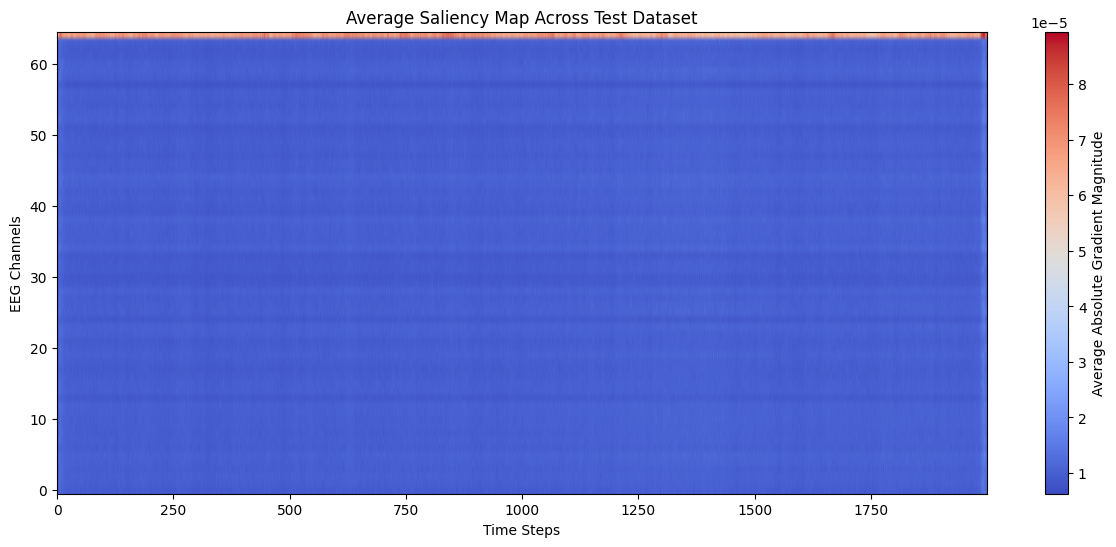

In [ ]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm # Using tqdm.notebook for progress bar in a notebook environment

# Assuming best_model, test_loader, test_set, and config are defined and available
# Make sure your best_model is loaded and in evaluation mode (best_model.eval())
# and moved to the correct device (best_model.to(config['device']))

if best_model is not None and test_loader is not None and test_set is not None:
    print("\n--- Generating Average Saliency Map ---")

    # Initialize a tensor to accumulate saliency maps
    # The shape should be (sequence_length, number_of_channels)
    # Get the shape from the first sample in the test set
    _, first_feature, _ = test_set[0]
    saliency_shape = first_feature.shape # Assuming shape is (seq_len, channels)
    total_saliency = torch.zeros(saliency_shape).to(config['device']) # Accumulate on the same device as the model

    total_samples = 0

    # Set model to evaluation mode
    best_model.eval()

    # Iterate through the test dataset
    # Use test_loader for batch processing
    for labels, features, original_labels in tqdm(test_loader, desc="Calculating Saliency Maps"):
        # Move data to the correct device
        features = features.to(config['device']).float()
        labels = labels.to(config['device']).float()


        # Enable gradient calculation for the input features
        features.requires_grad_()

        # Perform forward pass
        outputs = best_model(features)

        # Assuming binary classification with logits output
        # Calculate the loss or target output for backpropagation
        # For saliency, we want the gradient of the output w.r.t. the input
        # We can use the output logit directly or the loss w.r.t. the true label.
        # Let's use the output logit for simplicity to see general feature importance for the predicted class score.
        # If you want saliency w.r.t. the correct class score, you would use the target_output method from before.
        # For an average map over the whole dataset, the raw output might be more informative of general patterns.
        # Let's take the sum of the absolute outputs for simplicity in averaging across the dataset.
        # Alternatively, you could sum the gradients of the loss w.r.t. the input.
        # Let's stick to the gradient of the output logit as requested by the user's previous code structure.

        # Calculate the gradient of the outputs with respect to the input features
        # Sum the outputs for the backward pass to get gradients for the batch
        outputs.sum().backward()

        # Get the absolute gradients from the transposed features
        # The gradient shape will be the same as the input shape (batch_size, channels, seq_len)
        # Squeeze to remove batch dimension if batch_size is 1, abs for absolute magnitude
        # Transpose from (channels, seq_len) to (seq_len, channels) to match original feature shape
        saliency_batch = features.grad.abs().transpose(1, 2) # Shape (batch_size, seq_len, channels)

        # Accumulate the saliency maps
        total_saliency += saliency_batch.sum(dim=0) # Sum across the batch dimension

        # Count the number of samples processed
        total_samples += features.size(0)

        # Zero out gradients after processing the batch
        features.grad.zero_()

    # Calculate the average saliency map
    average_saliency = total_saliency / total_samples

    # Move the average saliency map to CPU for plotting
    average_saliency_np = average_saliency.cpu().numpy()

    # --- Visualize the Average Saliency Map ---
    print("\nVisualizing Average Saliency Map...")

    plt.figure(figsize=(15, 6))
    # Plot average saliency map with time on x-axis and channels on y-axis
    # imshow expects (height, width), so (channels, seq_len) after transpose
    plt.imshow(average_saliency_np.T, aspect='auto', cmap='coolwarm', origin='lower')
    plt.colorbar(label='Average Absolute Gradient Magnitude')
    plt.title('Average Saliency Map Across Test Dataset')
    plt.xlabel('Time Steps')
    plt.ylabel('EEG Channels')
    plt.show()

else:
    print("Model or test data not available. Cannot generate average saliency map.")

